In [1]:
# %matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
path = "datasets/Hirano3D/"
# data_path = Path(PATH)

In [4]:
_clss = {'NM17-002': 0,
         'Ctrl-AK': 0,
         'GUK1-D': 1, 
         'GUK1-R': 1,
         'MFN2-1': 2,
         'VCP-1': 3}

#### CV generation via sklearn, Multilabel implementation by trent-b, or FastAi

Both libraries seem to be completely useless... can just use native fastai function: get_cv_idxs().<br>
However, get_cv_idxs() does NOT shuffle...!

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

def get_label_stratified_CV_idxs(csv_path):
    
    _all_labels = pd.read_csv(csv_path)
    arr = _all_labels.values

    X = arr[:,0]
    y = arr[:,1:]
    
    ### sklearn.model_selection.StratifiedKFold
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    
    for train_index, val_index in sss.split(X, y):
        trn_idxs = train_index
        val_idxs = val_index
    
    print(f"""Train label-distribution:\n"""
          f"""{pd.Series(arr[:,1][trn_idxs]).value_counts()}""")
    print(f"""Val label-distribution:\n"""
          f"""{pd.Series(arr[:,1][val_idxs]).value_counts()}""")
    
    return trn_idxs, val_idxs


from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

def get_label_stratified_CV_idxs_multi(csv_path):
    
    # FastAi csv_source expects a folder-name string to be passed as first arg... -> 'dummy'
    X, y, all_lbls = csv_source('dummy', csv_path)
    
    ### Iterative stratification library: https://github.com/trent-b/iterative-stratification
    msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    
    for train_index, val_index in msss.split(X, y):
        trn_idxs = train_index
        val_idxs = val_index
    
    trn_count = np.sum(y[trn_idxs], axis=0)
    val_count = np.sum(y[val_idxs], axis=0)
    
    print(f"""Train label-distribution:\n"""
          f"""{trn_count}""")
    print(f"""Val label-distribution:\n"""
          f"""{val_count}""")
    
    return trn_idxs, val_idxs

In [6]:
### used atm...
csv_path = path + '8bit_multi_folder_Hirano3D_v1.csv'
trn_idxs, val_idxs = get_label_stratified_CV_idxs(csv_path)

Train label-distribution:
0    216
1    163
2    161
3    124
dtype: int64
Val label-distribution:
0    54
1    41
2    40
3    31
dtype: int64


In [64]:
import pickle

idxs_dict = {'trn_idxs': trn_idxs, 'val_idxs': val_idxs}

with open('datasets/Hirano3D/tmp/Hirano3D_dn121_local_8bit_idxs.pkl', 'wb') as handle:
    pickle.dump(idxs_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('datasets/Hirano3D/tmp/Hirano3D_dn121_local_8bit_idxs.pkl', 'rb') as handle:
    idxs_dict_load = pickle.load(handle)
    
val_idxs_loaded = idxs_dict_load['val_idxs']

In [7]:
# csv_path = path + 'multi_folder_Hirano3D_02.csv'
# trn_idxs, val_idxs = get_label_stratified_CV_idxs(csv_path)

In [8]:
# setting up a list of a random 20% of images in train as the validation set

# lbl_csv = path + 'multi_folder_Hirano3D_02.csv'
# n = len(list(open(lbl_csv))) -1
# val_idxs = get_cv_idxs(n, val_pct=0.2)


# # Count labels
# # _all_labels = pd.read_csv(PATH + 'multi_folder_Hirano3D_02.csv')
# # print(_all_labels.Targets.value_counts())

# _arr = _all_labels.values
# _val_labels = pd.DataFrame(_arr[val_idxs], columns=['Id','Targets'])
# print(_val_labels.Targets.value_counts())

### Define Dataloader:

In [9]:
def get_data(path, lbl_csv, val_idxs, sz, bs, aug_tfms):

    tfms = tfms_with_IntNorm(sz, aug_tfms=aug_tfms, crop_type=CropType.CENTER)
    data = ImageClassifierData.from_csv(PATH, 'data', lbl_csv, 
                                        val_idxs = val_idxs,
                                        test_name='data/8bit_Hirano3D_MaxP_GRFB_test_512', 
                                        tfms=tfms, bs=bs, suffix = '.tif', 
                                        balance=True, num_workers=0)
    return data

In [10]:
PATH = "datasets/Hirano3D"
# data_path = Path(PATH)

In [11]:
# define augmentations
augs = [RandomDihedral()]
NUM_CLASSES = 4
bs = 32
sz = [4,224,224]
lbl_csv = path + '8bit_multi_folder_Hirano3D_v1.csv'
# initialize data object
data = get_data(PATH, lbl_csv, val_idxs, sz, bs, aug_tfms = augs)

val_crop is: 2
Calculating weights...
one-hot encoding single-labels...
Weights calculated successfully!
Using WeightedRandomSampler


### inpsect data_loaders

In [ ]:
data.trn_dl.dataset.transform.tfms

In [12]:
x, y = next(iter(data.trn_dl))
im = to_np(x[0])
im.shape

(4, 224, 224)

In [ ]:
x, y = next(iter(data.val_dl))
# x_test, y_test = next(iter(data.test_dl))

In [ ]:
x[0].shape

In [ ]:
# print transformations
# plt.style.use('seaborn-white')

c = 0
idx = 0
fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    x, y = next(iter(data.aug_dl))
    im = to_np(x)[idx]
#     ax.imshow(np.sum(im, axis = 0))
    ax.imshow(im[c])

In [ ]:
from PIL import Image

In [ ]:
im_raw = tiff.imread('datasets\\Hirano3D\\test_out/fCMT2_02_e3_017.tif')
im_scaled = (im_raw/255)

im_sc_rot = np.moveaxis(im_scaled, 0,-1)

m = np.array(np.mean(im_sc_rot, axis=(0,1)), dtype=np.float32)
s = np.array(np.std(im_sc_rot, axis=(0,1)), dtype=np.float32)

im_scaled_normed = (im_sc_rot - m) / s
m_n = np.mean(im_scaled_normed[0])
s_n = np.std(im_scaled_normed[0])

print(np.mean(im_raw[0]))
print(np.mean(im_scaled[0]))
print(np.max(im_scaled_normed[0]))
print(m)

print(m_n, s_n)

im_raw.shape

In [ ]:
tiff.imshow(im_raw[0])

In [ ]:
# inspect images
plt.style.use('seaborn-white')
ch = 0
idx = 0

# im = to_np(x)[idx]
im_rawHPA = tiff.imread('datasets\\Kaggle_HPA_2018\\HPAv18_BGR_test\\1183_51_A11_2.tiff')
im_raw = tiff.imread('datasets\\Hirano3D\\test_out/fCMT2_02_e3_017.tif')
# im_scaled = (im_raw/255)


fig, ax = plt.subplots(1,2, figsize=(16,10))
ax[0].imshow(im_rawHPA[0])
ax[1].imshow(im_raw[ch])

In [ ]:
ch = 1

print(np.max(im_raw[ch]))
print(np.max(im_rawHPA[ch]))

In [ ]:
print(im_rawHPA[ch])

In [ ]:
plt.imshow(to_np(x)[5][2])

In [ ]:
# loading epoch for manual inspection...

In [ ]:
def load_epoch(dl = data.trn_dl):
    
    batch = iter(dl)

    xs = []
    ys = []

#     for b in range(0,len(dl)):
    for b in range(0,10):

        x_, y_ = next(batch)
        x_np, y_np = to_np(x_), to_np(y_)
        xs.append(x_np)
        ys.append(y_np)

    return np.vstack(xs), np.concatenate(ys)


### inpsecting loaded images and labels

In [ ]:
def to_label(y):
    ind = [i for i, p in enumerate(y) if y[i]==1]
    return(ind)

In [ ]:
# inspect train images
plt.style.use('seaborn-white')

idx = 2

im = to_np(x)[idx]

lbl = to_np(y)[idx]
# lbl = to_label(to_np(y)[idx])
print(lbl)

fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    ax.imshow(im[i])

In [ ]:
# inspect test images
plt.style.use('seaborn-white')

idx = 3

im = to_np(x_test)[idx]

# lbl = to_label(to_np(y)[idx])
# print(lbl)

fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    ax.imshow(im[i])

# training

In [ ]:
torch.cuda.is_available()

In [13]:
# base-model

arch = dn121_c
# arch = resnet50
learn = ConvLearner.pretrained(arch, data, opt_fn=optim.Adam, ps=0, pretrained=False)

In [14]:
# additional parameters

wd=1e-8 # weight-decay/L2 regularization 
# learn.metrics = [accuracy, f1_micro]

In [ ]:
learn.crit

In [16]:
learn.unfreeze()

In [ ]:
learn.lr_find2(1e-8)

In [ ]:
learn.sched.plot()

In [ ]:
learn.summary()

In [18]:
%time learn.fit(1e-3, 2, cycle_len=16, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='Hirano3D_v1_dn121_8bit_bs32_sz224_v2')

EPOCH 0 ---------------------------------------- STEP 0                                                                                                                                                                                      
epoch      trn_loss   val_loss   accuracy   
    0      1.39219    1.580265   0.277108  
EPOCH 1 ---------------------------------------- STEP 1                                                                                                                                                                                      
    1      1.353507   2.277456   0.277108  
EPOCH 2 ---------------------------------------- STEP 2                                                                                                                                                                                      
    2      1.347699   2.236724   0.204819  
EPOCH 3 ---------------------------------------- STEP 3                                                      

[array([1.13162]), 0.6024096378360886]

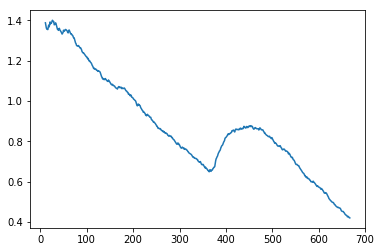

In [19]:
learn.sched.plot_loss()

In [20]:
%time learn.fit(6e-4, 1, cycle_len=16, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='Hirano3D_v1_dn121_8bit_bs32_sz224_v2_2')

EPOCH 0 ---------------------------------------- STEP 32                                                                                                                                                                                     
epoch      trn_loss   val_loss   accuracy   
    0      0.33739    1.329391   0.63253   
EPOCH 1 ---------------------------------------- STEP 33                                                                                                                                                                                     
    1      0.447565   1.642701   0.481928  
EPOCH 2 ---------------------------------------- STEP 34                                                                                                                                                                                     
    2      0.616699   1.485875   0.524096  
EPOCH 3 ---------------------------------------- STEP 35                                                     

[array([1.20696]), 0.614457830607173]

In [21]:
%time learn.fit(8e-4, 4, cycle_len=8, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='Hirano3D_v1_dn121_8bit_bs32_sz224_v2_2')

EPOCH 0 ---------------------------------------- STEP 48                                                                                                                                                                                     
epoch      trn_loss   val_loss   accuracy   
    0      0.322217   1.600793   0.53012   
EPOCH 1 ---------------------------------------- STEP 49                                                                                                                                                                                     
    1      0.584379   1.557682   0.506024  
EPOCH 2 ---------------------------------------- STEP 50                                                                                                                                                                                     
    2      0.636146   1.718524   0.427711  
EPOCH 3 ---------------------------------------- STEP 51                                                     

[array([1.26215]), 0.6265060248145138]

In [22]:
%time learn.fit(1e-4, 4, cycle_len=8, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='Hirano3D_v1_dn121_8bit_bs32_sz224_v2_3')

EPOCH 0 ---------------------------------------- STEP 80                                                                                                                                                                                     
epoch      trn_loss   val_loss   accuracy   
    0      0.14351    1.222646   0.626506  
EPOCH 1 ---------------------------------------- STEP 81                                                                                                                                                                                     
    1      0.126164   1.403043   0.614458  
EPOCH 2 ---------------------------------------- STEP 82                                                                                                                                                                                     
    2      0.126797   1.38206    0.626506  
EPOCH 3 ---------------------------------------- STEP 83                                                     

[array([1.39335]), 0.6626506031277668]

In [23]:
%time learn.fit(5e-5, 4, cycle_len=8, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='Hirano3D_v1_dn121_8bit_bs32_sz224_v2_4')

EPOCH 0 ---------------------------------------- STEP 112                                                                                                                                                                                    
epoch      trn_loss   val_loss   accuracy   
    0      0.031391   1.463439   0.644578  
EPOCH 1 ---------------------------------------- STEP 113                                                                                                                                                                                    
    1      0.030422   1.452      0.662651  
EPOCH 2 ---------------------------------------- STEP 114                                                                                                                                                                                    
    2      0.025333   1.463051   0.63253   
EPOCH 3 ---------------------------------------- STEP 115                                                    

[array([1.52685]), 0.6445783139711403]

In [24]:
%time learn.fit(1e-5, 4, cycle_len=8, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='Hirano3D_v1_dn121_8bit_bs32_sz224_v2_5')

EPOCH 0 ---------------------------------------- STEP 144                                                                                                                                                                                    
epoch      trn_loss   val_loss   accuracy   
    0      0.026007   1.542364   0.650602  
EPOCH 1 ---------------------------------------- STEP 145                                                                                                                                                                                    
    1      0.019589   1.562376   0.644578  
EPOCH 2 ---------------------------------------- STEP 146                                                                                                                                                                                    
    2      0.019904   1.573586   0.63253   
EPOCH 3 ---------------------------------------- STEP 147                                                    

[array([1.50059]), 0.6385542175855982]

In [25]:
%time learn.fit(5e-6, 4, cycle_len=8, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='Hirano3D_v1_dn121_8bit_bs32_sz224_v2_6')

EPOCH 0 ---------------------------------------- STEP 176                                                                                                                                                                                    
epoch      trn_loss   val_loss   accuracy   
    0      0.011268   1.535957   0.662651  
EPOCH 1 ---------------------------------------- STEP 177                                                                                                                                                                                    
    1      0.012036   1.481114   0.656627  
EPOCH 2 ---------------------------------------- STEP 178                                                                                                                                                                                    
    2      0.010604   1.524911   0.644578  
EPOCH 3 ---------------------------------------- STEP 179                                                    

[array([1.5552]), 0.6566265067422247]

In [ ]:
%time learn.fit(1e-5, 4, cycle_len=8, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='Hirano3D_v1_dn121_8bit_bs32_sz224_v2_7')

In [ ]:
%time learn.fit(1e-4, 2, cycle_len=16, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='Hirano3D_v1_dn121_8bit_bs32_sz224_v2')

In [ ]:
%time learn.fit(1e-3, 2, cycle_len=16, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

In [ ]:
learn.sched.plot_lr()

In [ ]:
%time learn.fit(6e-4, 2, cycle_len=16, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

In [ ]:
wd = 1e-10
%time learn.fit(6e-4, 2, cycle_len=16, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

In [ ]:
# define augmentations
augs = [RandomDihedral()]
NUM_CLASSES = 4
bs = 64
sz = [4,256,256]
lbl_csv = path + '8bit_multi_folder_Hirano3D_v1.csv'
# initialize data object
data_64_256 = get_data(PATH, lbl_csv, val_idxs, sz, bs, aug_tfms = augs)
learn.set_data(data_64_256)

In [ ]:
learn.data.bs

In [ ]:
%time learn.fit(1e-3, 1, cycle_len=4, wds=wd, use_wd_sched=True)

In [ ]:
%time learn.fit(1e-3, 1, cycle_len=24, wds=wd, use_wd_sched=True)

In [ ]:
%time learn.fit(1e-2, 5, wds=wd, use_wd_sched=True)

In [ ]:
%time learn.fit(8e-3, 6, wds=wd, use_wd_sched=True)

In [ ]:
%time learn.fit(1e-3, 2, cycle_len=8, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

In [ ]:
%time learn.fit(8e-4, 1, cycle_len=16, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

In [ ]:
learn.sched.plot_lr()

In [ ]:
%time learn.fit(3e-4, 1, cycle_len=16, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

In [ ]:
%time learn.fit(1e-4, 1, cycle_len=16, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

In [ ]:
learn.lr_find2()

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.save('Hirano3D_v1_dn121_bs128_128_1_42')

In [ ]:
# define augmentations
augs = [RandomDihedral()]
NUM_CLASSES = 4
bs = 64
sz = [4,128,128]

lbl_csv = path + '8bit_multi_folder_Hirano3D_v1.csv'
# initialize data object
data_64_128 = get_data(PATH, lbl_csv, val_idxs, sz, bs, aug_tfms = augs)
learn.set_data(data_64_128)

In [ ]:
learn.data.sz

In [ ]:
learn.lr_find2()
learn.sched.plot_lr()

In [ ]:
# training loops:

In [ ]:
learn.sched.__dict__.keys()

In [ ]:


_per_iter = [[i, learn.sched.losses[idx], learn.sched.lrs[idx]] for idx, i in enumerate(learn.sched.iterations)]
_per_iter = pd.DataFrame(per_iter, columns=['Iteration', 'trn_loss', 'lr'])
per_iter_df.append(_per_iter)

if learn.sched.glob_step: 
    per_iter_df = _per_iter
    print('created')
else: 
    per_iter_df.append(_per_iter)
    print('appended')

In [ ]:
learn.sched.plot_lr()

In [ ]:
%time learn.fit(1e-2, 2, cycle_len=1, wds=wd, use_wd_sched=True)

In [ ]:
learn.sched.Glob_lrs

In [ ]:
learn.sched.plot_loss()

In [ ]:
%time learn.fit(1e-4, 8, cycle_len=1, wds=wd, use_wd_sched=True)

In [ ]:
%time learn.fit(1e-5, 4, cycle_len=8, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

In [ ]:
%time learn.fit(1e-4, 2, cycle_len=16, cycle_mult=2, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

In [ ]:
%time learn.fit(2e-5, 1, cycle_len=8, cycle_mult=2, wds=wd, use_wd_sched=True)

In [ ]:
lr = (5e-4, 1e-3, 5e-3)

In [ ]:
sz = [4,516, 516]
learn.set_data(get_data(PATH, lbl_csv, val_idxs, sz, bs, aug_tfms = augs))

In [ ]:
%time learn.fit(1e-3, 1, cycle_len=8, cycle_mult=2, wds=wd, use_wd_sched=True)

In [ ]:
%time learn.fit(1e-3, 2, cycle_len=8, wds=wd, use_wd_sched=True)

In [ ]:
learn.save('Hirano3D_v1_ResNet18_512_72')

## test-predictions

In [48]:
learn.load('Hirano3D_v1_dn121_8bit_bs32_sz224_v2')

In [49]:
learn.freeze()

In [51]:
learn.warm_up(1e-10)

EPOCH 0 ---------------------------------------- STEP 208                                                                                                                                                                                    
epoch      trn_loss   val_loss   accuracy   
    0      0.245818   1.127193   0.572289  

appending existing log-files...
log-files saved to: datasets/Hirano3D


[array([1.12719]), 0.5722891559083778]

In [ ]:
log_preds, y = learn.predict_with_targs()
preds = np.argmax(log_preds, axis=1)
print(preds)

In [52]:
log_preds, y =  learn.TTA()

[[31  4  7  6]
 [ 2 24  6  4]
 [11  2 29  6]
 [ 8  4  4 18]]


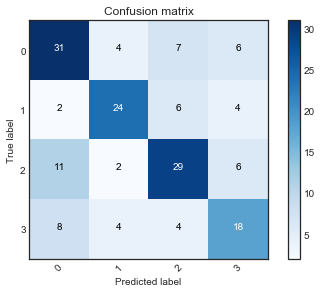

In [53]:
# Plot confusion matrix 
plt.style.use('seaborn-white')
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

In [ ]:
log_preds, y =  learn.TTA(is_test=True)
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
print(preds)

In [34]:
learn.models.model._modules

OrderedDict([('0', Sequential(
                (conv0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
                (relu0): ReLU(inplace)
                (pool0): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
                (denseblock1): _DenseBlock(
                  (denselayer1): _DenseLayer(
                    (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
                    (relu1): ReLU(inplace)
                    (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
                    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
                    (relu2): ReLU(inplace)
                    (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  )
                  (denselayer2): _DenseLayer(
                    

In [54]:
# function to be called by register_forward_hook

def get_embeddings(layer_name):
    def register_hook(layer_name):
        def get_embedding(layer, inp, outp):
            tmp = inp[0]
            embedding.append(tmp)

        hook = layer.register_forward_hook(get_embedding) 
        
        for i in ['trn', 'val', 'test']:
            embedding = []
            preds, y = learn.predict_with_targs(i)
            
            # populating dict, consiting of [0]: preds, [1]: y, [2]: activations[layer]
            embeddings[i] = [preds, y, np.vstack(to_np(embedding))]
            
        hook.remove()
        
    embeddings = {}    
    layer = learn.models.model._modules.get(layer_name)
    register_hook(layer)
    
    return embeddings

In [55]:
embeddings = get_embeddings('7')

In [56]:
# unpacking embeddings

embs_trn = embeddings['trn'][2]
y_trn = embeddings['trn'][1]

embs_val = embeddings['val'][2]
y_val = embeddings['val'][1]

embs_test = embeddings['test'][2]
y_test = embeddings['test'][1]

print(embs_trn.shape)
print(embs_val.shape)
print(embs_test.shape)

print(y_trn.shape)
print(y_val.shape)
print(y_test.shape)


(664, 512)
(166, 512)
(60, 512)
(664,)
(166,)
(60,)


In [57]:
import umap

In [58]:
UMAP_trn_embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.3,
                      metric='correlation').fit(embs_trn)

UMAP_trn = UMAP_trn_embedding.embedding_
UMAP_val = UMAP_trn_embedding.transform(embs_val)
UMAP_test = UMAP_trn_embedding.transform(embs_test)

In [59]:
# data.test_ds.fnames

In [60]:
y_test = np.zeros(60)
y_test[:30] = y_test[:30] +1 
y_test

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [1]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in range(4):
    trn_UMAP_cls = UMAP_trn[y_trn == i]

    axarr[0].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5)
    axarr[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
#     if i == 0:
#         axarr[1].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5)

#     axarr[0].set_xlim(-10,5)
#     axarr[0].set_ylim(-5,8)
    
for i in range(4):
    test_UMAP_cls = UMAP_val[y_val == i]
    
    axarr[1].scatter(test_UMAP_cls[:,compA], test_UMAP_cls[:,compB], s = 5)
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     axarr[1].set_xlim(-10,5)
#     axarr[1].set_ylim(-5,8)


NameError: name 'plt' is not defined

In [ ]:
def opt_th(preds, targs, start=0.2, end=0.6, step=0.05):
    ths = np.arange(start,end,step)
    res = [f1_macro(preds, targs, thresh=th, kind='macro') for th in ths]
    idx = np.argmax(res)
    return ths[idx], res

In [ ]:
# get train predictions

preds_trn, targs_trn =  learn.predict_with_targs('trn')

preds_trn_torch = torch.from_numpy(preds_trn)
targs_trn_torch = torch.from_numpy(targs_trn)

opt_th(preds_trn_torch, targs_trn_torch)

In [ ]:
print(preds_val_torch[0])
print(preds_trn_torch[0])

In [ ]:
# get val predictions

preds_val, targs_val =  learn.predict_with_targs('val')

preds_val_torch = torch.from_numpy(preds_val)
targs_val_torch = torch.from_numpy(targs_val)

opt_th(preds_val_torch, targs_val_torch)

In [ ]:
# get test predictions

preds_test, targs_test =  learn.predict_with_targs('test')

In [ ]:
targs_test[:50]

In [ ]:
def load_epoch(dl = data.trn_dl):
    
    batch = iter(dl)

    xs = []
    ys = []

#     for b in range(0,len(dl)):
    for b in range(0,10):

        x_, y_ = next(batch)
        x_np, y_np = to_np(x_), to_np(y_)
        xs.append(x_np)
        ys.append(y_np)

    return np.vstack(xs), np.concatenate(ys)

In [ ]:
data.test_dl.sampler

In [ ]:
test_names = data.test_ds.fnames
test_names[:10]

In [ ]:
def create_submission(preds_file, output_name, th = 0.3, TTA=False):
    
    # creating submission file
    
    if TTA:
        preds = preds_file.mean(axis=0)
        print('TTA:',preds.shape)
    else: preds = preds_file
    
    clss = np.arange(0, len(data.classes)) # get class indeces
    res = np.array([' '.join(np.char.mod('%d', clss[np.where(p > th)])) for p in preds]) # generating output

    # ensure that there are no empty cells: in case no value > thresh, fill in with argmax()
    for i in range(res.shape[0]):
        if res[i] == '':
            res[i] = preds[i].argmax()

    # getting image Ids
    fnames = np.array([os.path.basename(im).split('.')[0] for im in data.test_ds.fnames])

    # creating submission file
    sub_df = pd.DataFrame(res, index=fnames, columns=['Predicted'])
    sub_df.to_csv(output_name, index_label='Id')

In [ ]:
submission_name = PATH + 'submissions/Res18_pre_0.42_t-03.csv'

create_submission(log_preds, submission_name, th=0.3, TTA=True)

## other stuff

In [ ]:
# List of label identities:

cell_location_label = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [ ]:
# from sklearn.metrics import f1_score

# thresholds = np.linspace(0, 1, 1000)
# score = 0.0
# test_threshold=0.5*np.ones(28)
# best_threshold=np.zeros(28)
# best_val = np.zeros(28)
# for i in range(28):
#     for threshold in thresholds:
#         test_threshold[i] = threshold
#         max_val = np.max(preds_y)
#         val_predict = (preds_y > test_threshold)
#         score = f1_score(valid_y > 0.5, val_predict, average='macro')
#         if score > best_val[i]:
#             best_threshold[i] = threshold
#             best_val[i] = score
#     print("Threshold[%d] %0.6f, F1: %0.6f" % (i,best_threshold[i],best_val[i]))
#     test_threshold[i] = best_threshold[i]
# print("Best threshold: ")
# print(best_threshold)
# print("Best f1:")
# print(best_val)